## Ensemble Modeling
- Log 및 모델링 결과에 대한 기록은 sacred를 통해 진행

In [24]:
import os
import json
import warnings
from utils import info, split_train_and_test_period, evaluation, split_x_and_y, split_x_and_y_log, parsing_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [8]:
# 모델링 결과를 저장하기 위한 Path 설정
SAVE_PATH = os.path.join(os.path.split(os.getcwd())[0], 'airflow/data/taxi-demand-prediction')
SAVE_PATH

'/Users/aeea/Desktop/git/project/taxi-demand-repo/airflow/data/taxi-demand-prediction'

In [9]:
# 모델링 결과를 저장할 객체를 생성하는 함수
def make_experiment(name, save_path, interactive=True):
    # 실험을 위한 Experiment 객체 생성
    ex = Experiment(name, interactive=interactive)

    experiment_dir = os.path.join(save_path, 'experiments')
    if not os.path.isdir(experiment_dir):
        os.mkdir(experiment_dir)

    # 실험의 모든 정보를 저장하기 위해 FileStorageObserver 객체를 ex.observers에 저장
    ex.observers.append(FileStorageObserver.create(experiment_dir))
    print("Make Experiment Object.")
    
    return ex

### 데이터 로드 & 전처리
- Baseline의 Input Dataset과 동일

In [25]:
base_query = """
WITH base_data AS (
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            (EXTRACT(MONTH FROM pickup_datetime) = 1)
            and (pickup_latitude BETWEEN -90 AND 90)
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT
    zip_code,
    pickup_hour,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    cnt
FROM (
    SELECT 
        DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
        count(*) AS cnt,
        zip_code
    FROM base_data
    GROUP BY pickup_hour, zip_code
)
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

In [11]:
base_df.tail(2)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
87018,11208,2015-01-31 23:00:00,1,31,5,23,1,1
87019,11213,2015-01-31 23:00:00,1,31,5,23,1,1


---

### XGBoost Regressor

#### 1. Log Scaling을 적용하지 않은 XGBoost Model

In [5]:
# Label Encoding
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

# Train % Test Split
train_df, test_df = split_train_and_test_period(base_df, 7)

# X & y Split
x_train, x_test, y_train, y_test = split_x_and_y(train_df, test_df, y='cnt')

In [27]:
# 결과를 기록할 객체 생성
ex = make_experiment('nyc-demand-prediction', SAVE_PATH)

Make Experiment Object.


In [20]:
# ex에 Modeling Process 및 Log에 저장할 데이터 설정
@ex.config
def config():
    booster = ['gbtree', 'gblinear']
    n_estimators = [100, 300, 500, 700, 1000]
    max_depth = [3, 5, 7, 9, 11]
    learning_rate = [0.01, 0.05, 0.1]
    subsample = [0.5, 0.75, 1.0]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric': 'rmse',
        'eval_set': [(x_test, y_test)]
    }
    
    
@ex.capture
def get_grid_model(booster, n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight):
    params = [{
        'booster': booster,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    rnd_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, n_iter=200, cv=3,
                                    scoring='neg_mean_squared_error', verbose=0,
                                    n_jobs=os.cpu_count()-4, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run, fit_params):
    global grid_xgb_reg, y_pred
    
    grid_xgb_reg = get_grid_model()
    grid_xgb_reg.fit(x_train, y_train, groups=None, **fit_params, verbose=0)
    
    y_pred = grid_xgb_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_xgb_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_xgb_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [9]:
# 모델링 진행
%%time
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "1"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 252.00139530495957}, 'mae': {'score': 38.67050307894591}, 'mse': {'score': 12708.977889446205}}
INFO - nyc-demand-prediction - Completed after 0:07:12


CPU times: user 11.5 s, sys: 1.17 s, total: 12.7 s
Wall time: 7min 13s


In [14]:
# 모델의 Parameter 정보 및 모델링 결과
print(parsing_output(1)['config']['score'])
parsing_output(1)

[{"booster": "gbtree", "colsample_bytree": 1.0, "learning_rate": 0.1, "max_depth": 7, "min_child_weight": 3.0, "n_estimators": 500, "subsample": 0.75}]


,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.0,12708.98


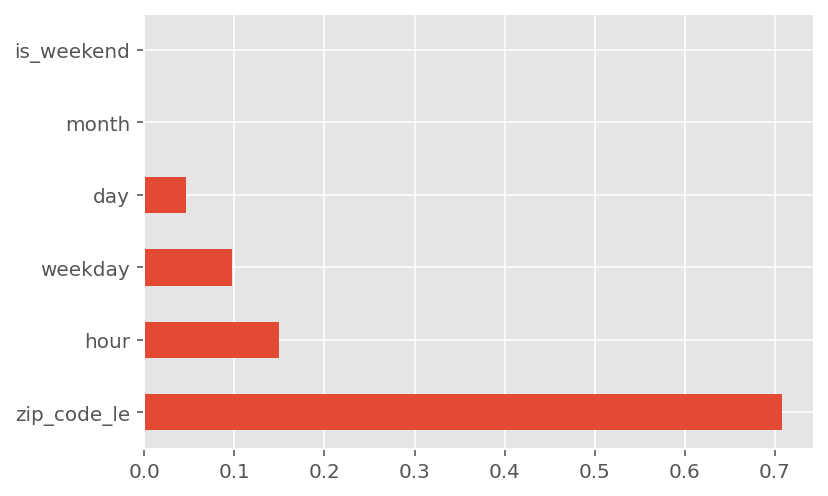

In [12]:
# Feature Importance Visualization
feat_importances = pd.Series(grid_xgb_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

#### 2. Log Scaling을 적용한 XGBoost Model

In [13]:
# Log Scaling
base_df['log_cnt'] = np.log10(base_df['cnt'])

# Label Encoding
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

# Train % Test Split
train_df, test_df = split_train_and_test_period(base_df, 7)

# X & y Split
x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [15]:
ex = make_experiment('nyc-demand-prediction', SAVE_PATH)

Make Experiment Object.


In [21]:
@ex.config
def config():
    booster = ['gbtree', 'gblinear']
    n_estimators = [100, 300, 500, 700, 1000]
    max_depth = [3, 5, 7, 9, 11]
    learning_rate = [0.01, 0.05, 0.1]
    subsample = [0.5, 0.75, 1.0]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric': 'rmse',
        'eval_set': [(x_test, y_test_log)]
    }
    
    
@ex.capture
def get_grid_model(booster, n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight):
    params = [{
        'booster': booster,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    rnd_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, n_iter=200, cv=3,
                                    scoring='neg_mean_squared_error', verbose=0,
                                    n_jobs=os.cpu_count()-4, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run, fit_params):
    global grid_xgb_reg, y_pred
    
    grid_xgb_reg = get_grid_model()
    grid_xgb_reg.fit(x_train, y_train_log, groups=None, **fit_params, verbose=0)
    
    y_pred = grid_xgb_reg.best_estimator_.predict(x_test)
    y_pred_reverse = 10**y_pred
    
    score = evaluation(y_test_raw, y_pred_reverse)
    
    _run.log_scalar('model_name', grid_xgb_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_xgb_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [18]:
%%time
experiment_result_2 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "2"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 157.25449150510462}, 'mae': {'score': 34.77152604375481}, 'mse': {'score': 11397.454287826673}}
INFO - nyc-demand-prediction - Completed after 0:08:53


CPU times: user 15.8 s, sys: 1.29 s, total: 17.1 s
Wall time: 8min 52s


In [15]:
# 모델2의 parameter 정보 및 모델 1, 2에 대한 성능 비교
print(parsing_output(2)['config']['score'])
pd.concat([parsing_output(1), parsing_output(2)])

[{"booster": "gbtree", "colsample_bytree": 1.0, "learning_rate": 0.05, "max_depth": 11, "min_child_weight": 1.0, "n_estimators": 1000, "subsample": 0.5}]


,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.00,12708.98
score,XGBRegressor,2,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",34.77,157.25,11397.45


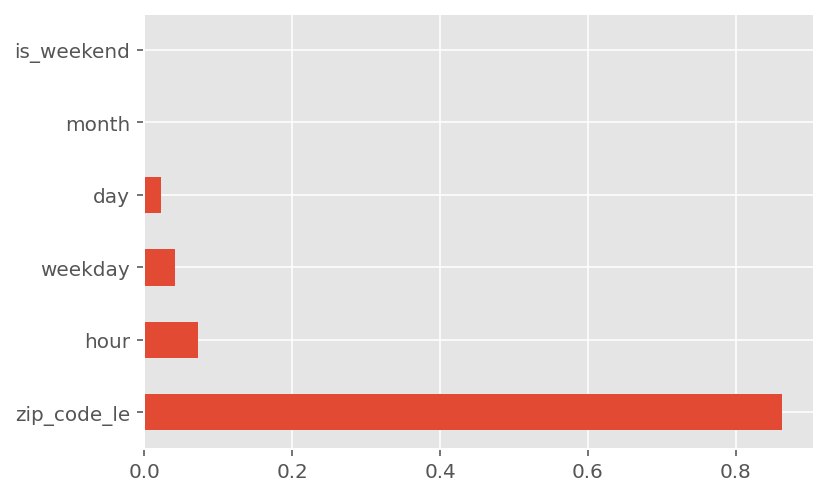

In [21]:
feat_importances = pd.Series(grid_xgb_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

---

### Lightgbm Regressor

#### 3. Log Scaling을 적용하지 않은 LightGBM Model

In [24]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

train_df, test_df = split_train_and_test_period(base_df, 7)

x_train, x_test, y_train, y_test = split_x_and_y(train_df, test_df, y='cnt')

In [16]:
ex = make_experiment('nyc-demand-prediction', SAVE_PATH)

Make Experiment Object.


In [28]:
@ex.config
def config():
    boosting_type = ['rf', 'gbdt', 'goss']
    n_estimators = [100, 300, 500, 700, 1000]
    max_depth = [3, 5, 7, 9, 11]
    learning_rate = [0.01, 0.05, 0.1]
    subsample = [0.5, 0.75, 1.0]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric': 'rmse',
        'eval_set': [(x_test, y_test)]
    }
    
    
@ex.capture
def get_grid_model(boosting_type, n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight):
    params = [{
        'boosting_type': boosting_type,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    
    rnd_search = RandomizedSearchCV(LGBMRegressor(), param_distributions=params, n_iter=200, cv=3,
                                    scoring='neg_mean_squared_error', verbose=0,
                                    n_jobs=os.cpu_count()-4, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run, fit_params):
    global grid_lgbm_reg, y_pred
    
    grid_lgbm_reg = get_grid_model()
    grid_lgbm_reg.fit(x_train, y_train, groups=None, **fit_params, verbose=0)
    
    y_pred = grid_lgbm_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_lgbm_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_lgbm_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [29]:
%%time
experiment_result_3 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "3"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 285.97207158262756}, 'mae': {'score': 40.9389040130079}, 'mse': {'score': 13411.78761327463}}
INFO - nyc-demand-prediction - Completed after 0:02:06


CPU times: user 13.9 s, sys: 3.15 s, total: 17 s
Wall time: 2min 6s


In [21]:
print(parsing_output(3)['config']['score'])
pd.concat([parsing_output(1), parsing_output(2), parsing_output(3)])

[{"boosting_type": "goss", "colsample_bytree": 1.0, "learning_rate": 0.05, "max_depth": 9, "min_child_weight": 3.0, "n_estimators": 1000, "subsample": 0.75}]


,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.00,12708.98
score,XGBRegressor,2,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",34.77,157.25,11397.45
score,LGBMRegressor,3,"[{""boosting_type"": ""goss"", ""colsample_bytree"":...",40.94,285.97,13411.79


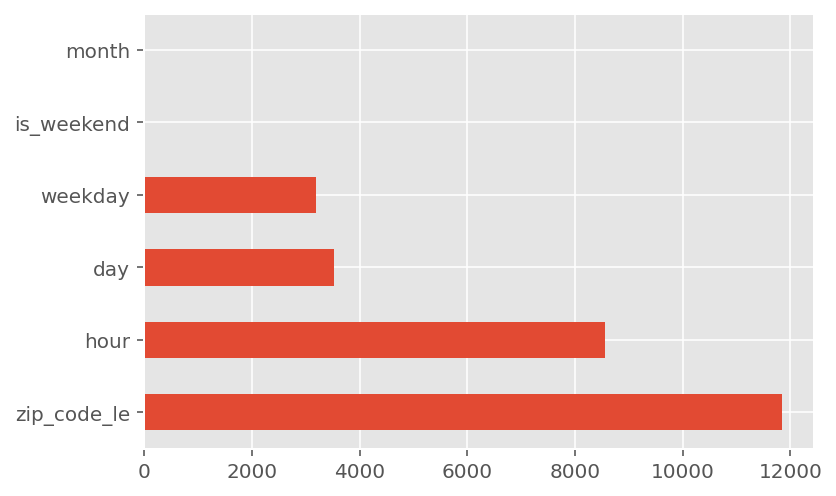

In [31]:
feat_importances = pd.Series(grid_lgbm_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

#### 4. Log Scaling을 적용한 LightGBM Model

In [32]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

train_df, test_df = split_train_and_test_period(base_df, 7)

x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [17]:
ex = make_experiment('nyc-demand-prediction', SAVE_PATH)

Make Experiment Object.


In [34]:
@ex.config
def config():
    boosting_type = ['rf', 'gbdt', 'goss']
    n_estimators = [100, 300, 500, 700, 1000]
    max_depth = [3, 5, 7, 9, 11]
    learning_rate = [0.01, 0.05, 0.1]
    subsample = [0.5, 0.75, 1.0]
    colsample_bytree = [0.5, 0.75, 1.0]
    min_child_weight = [1.0, 3.0]
    
    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric': 'rmse',
        'eval_set': [(x_test, y_test_log)]
    }
    
    
@ex.capture
def get_grid_model(boosting_type, n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight):
    params = [{
        'boosting_type': boosting_type,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
        }]
    
    rnd_search = RandomizedSearchCV(LGBMRegressor(), param_distributions=params, n_iter=200, cv=3,
                                    scoring='neg_mean_squared_error', verbose=0,
                                    n_jobs=os.cpu_count()-4, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run, fit_params):
    global grid_lgbm_reg, y_pred
    
    grid_lgbm_reg = get_grid_model()
    grid_lgbm_reg.fit(x_train, y_train_log, groups=None, **fit_params, verbose=0)
    
    y_pred = grid_lgbm_reg.best_estimator_.predict(x_test)
    y_pred_reverse = 10**y_pred
    
    score = evaluation(y_test_raw, y_pred_reverse)
    
    _run.log_scalar('model_name', grid_lgbm_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_lgbm_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [35]:
%%time
experiment_result_4 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "4"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 155.94740414948117}, 'mae': {'score': 36.742807363185584}, 'mse': {'score': 12422.035603193515}}
INFO - nyc-demand-prediction - Completed after 0:02:33


CPU times: user 12.4 s, sys: 3.69 s, total: 16.1 s
Wall time: 2min 33s


In [20]:
print(parsing_output(4)['config']['score'])
pd.concat([parsing_output(1), parsing_output(2), parsing_output(3), parsing_output(4)])

[{"boosting_type": "gbdt", "colsample_bytree": 0.75, "learning_rate": 0.1, "max_depth": 7, "min_child_weight": 3.0, "n_estimators": 1000, "subsample": 0.5}]


,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.00,12708.98
score,XGBRegressor,2,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",34.77,157.25,11397.45
score,LGBMRegressor,3,"[{""boosting_type"": ""goss"", ""colsample_bytree"":...",40.94,285.97,13411.79
score,LGBMRegressor,4,"[{""boosting_type"": ""gbdt"", ""colsample_bytree"":...",36.74,155.95,12422.04


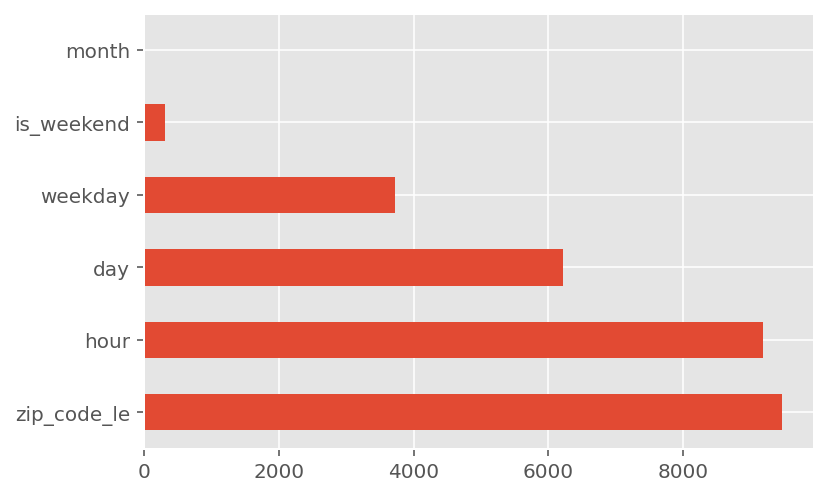

In [37]:
feat_importances = pd.Series(grid_lgbm_reg.best_estimator_.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

---

### RandomForest Regressor
- Random Forest 에는 early stopping이 없기에 fit_params 사용 X

#### 5. Log Scaling을 적용하지 않은 RandomForest Model

In [40]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

train_df, test_df = split_train_and_test_period(base_df, 7)

x_train, x_test, y_train, y_test = split_x_and_y(train_df, test_df, y='cnt')

In [18]:
ex = make_experiment('nyc-demand-prediction', SAVE_PATH)

Make Experiment Object.


In [42]:
@ex.config
def config():
    n_estimators = [100, 300, 500, 700, 1000]
    max_depth = [3, 5, 7, 9, 11]
    max_samples = [0.5, 0.75, None] # None이 x.shape[0]이기에 1.0과 같음
    max_features = ['auto', 'sqrt', 'log2']
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = ['True', 'False']
    
    
@ex.capture
def get_grid_model(n_estimators, max_depth, max_samples, max_features, min_samples_split, min_samples_leaf, bootstrap):
    params = [{
        'n_estimators': n_estimators, 
        'max_depth': max_depth,
        'max_samples': max_samples, # 각 예측기에 샘플들이 랜덤하게 몇%씩 들어가는지 setting
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
        }]
    rnd_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=200, cv=3,
                                    scoring='neg_mean_squared_error', verbose=0,
                                    n_jobs=os.cpu_count()-4, random_state=13)
    
    return rnd_search


@ex.main
def run(_log, _run):
    global grid_rf_reg, y_pred
    
    grid_rf_reg = get_grid_model()
    grid_rf_reg.fit(x_train, y_train)
    
    y_pred = grid_rf_reg.best_estimator_.predict(x_test)
    
    score = evaluation(y_test, y_pred)
    
    _run.log_scalar('model_name', grid_rf_reg.best_estimator_.__class__.__name__)
    _run.log_scalar('model_params', grid_rf_reg.best_params_)
    _run.log_scalar('score', score)
    
    return score.to_dict()

In [43]:
%%time
experiment_result_4 = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "5"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 235.08115815034412}, 'mae': {'score': 44.32385465561981}, 'mse': {'score': 15981.149672638623}}
INFO - nyc-demand-prediction - Completed after 0:13:50


CPU times: user 19.4 s, sys: 943 ms, total: 20.4 s
Wall time: 13min 50s


In [22]:
print(parsing_output(5)['config']['score'])

[{"bootstrap": "True", "max_depth": 11, "max_features": "auto", "max_samples": 0.75, "min_samples_leaf": 1, "min_samples_split": 2, "n_estimators": 500}]


---

---

## Best Model 선정 및 결과 분석

### Best Model Selection
- MSE가 11397.45으로, 성능이 가장 좋은 Log Scaling이 적용된 XGBRegressor Model을 Best Model로 선정 (Experiment_2)

In [26]:
results = [parsing_output(i) for i in range(1, 6)]

pd.concat(results).sort_values('mse')

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,2,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",34.77,157.25,11397.45
score,LGBMRegressor,4,"[{""boosting_type"": ""gbdt"", ""colsample_bytree"":...",36.74,155.95,12422.04
score,XGBRegressor,1,"[{""booster"": ""gbtree"", ""colsample_bytree"": 1.0...",38.67,252.00,12708.98
score,LGBMRegressor,3,"[{""boosting_type"": ""goss"", ""colsample_bytree"":...",40.94,285.97,13411.79
score,RandomForestRegressor,5,"[{""bootstrap"": ""True"", ""max_depth"": 11, ""max_f...",44.32,235.08,15981.15


### Best Model에 대한 모델링

In [31]:
# Model에 대한 parameter 추출
best_params = json.loads(parsing_output(2)['config']['score'])[0]
print(best_params)

# 모델링을 위한 전처리
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

base_df['log_cnt'] = np.log10(base_df['cnt'])

train_df, test_df = split_train_and_test_period(base_df, 7)

x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

# 모델 학습
best_model = XGBRegressor(**best_params, random_state=13)
best_model.fit(x_train, y_train_log)

# Prediction
y_pred = best_model.predict(x_test)
y_pred_reverse = 10**y_pred

{'booster': 'gbtree', 'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 11, 'min_child_weight': 1.0, 'n_estimators': 1000, 'subsample': 0.5}


### 결과 분석

#### 1. Best Model의 metric 성능 평가

In [32]:
evaluation(y_test_raw, y_pred_reverse)

,mape,mae,mse
score,169.090953,34.766009,12130.159375


#### 2. 실제값과 예측값간 비교를 통한 성능 평가

In [33]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = y_pred_reverse

test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

test_df.tail(2)

#### Datetime별 차이

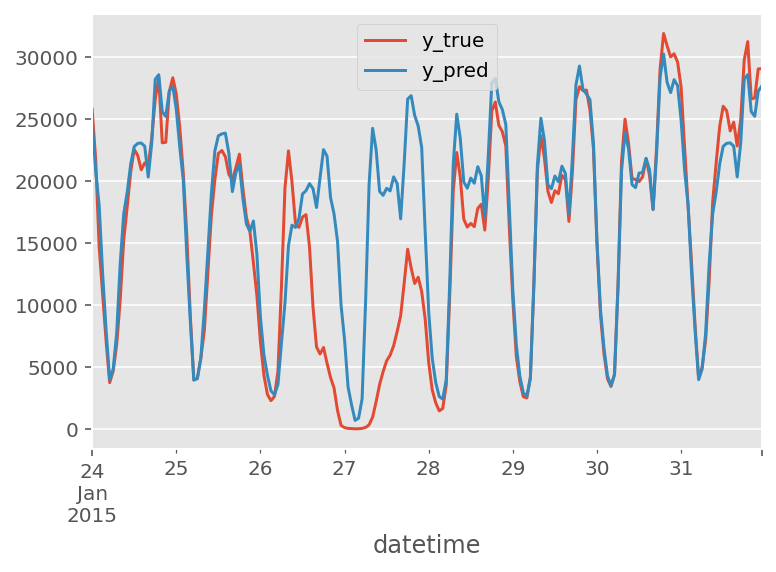

In [35]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

#### hour별 차이
- 새벽 시간엔 거의 유사하다가 7시부터 20시까지 실제값에 비해 예측값이 비교적 높게 예측된다는 것을 알 수 있다.

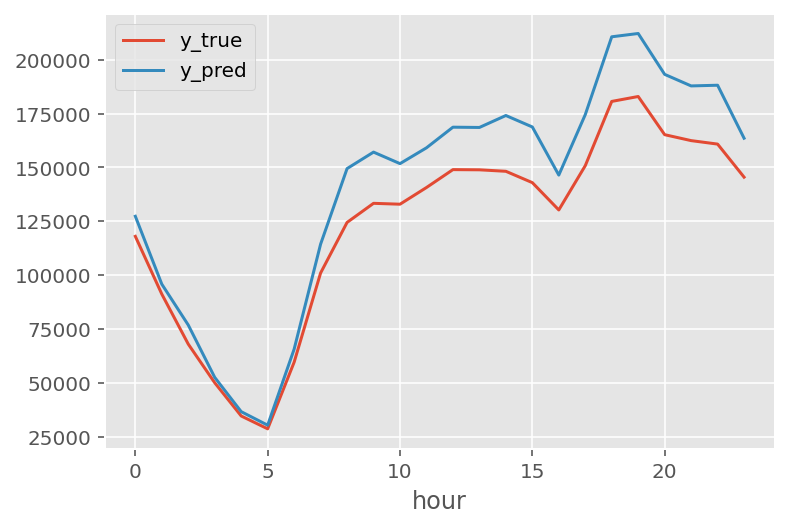

In [36]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

#### Weekday별 차이
- 평일 중 월, 화에 실제값보다 예측값이 높게 예측되며 그 외 나머지 요일에 대해서는 예측성능이 좋다고 볼 수 있다.

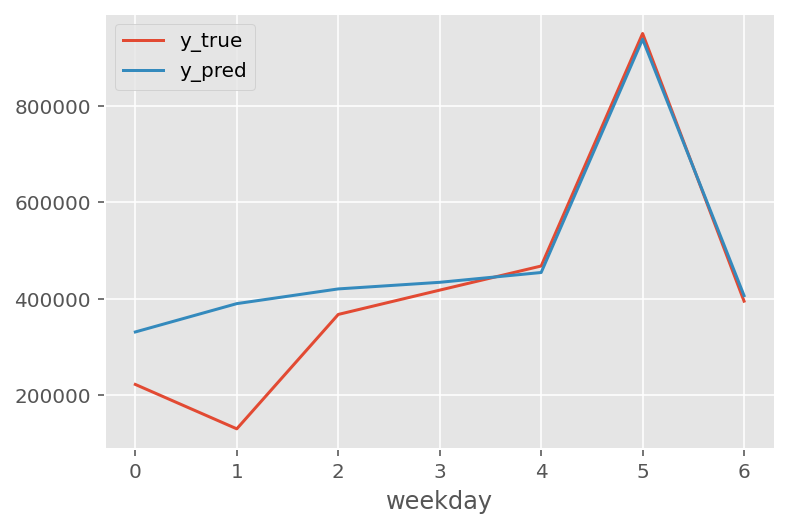

In [37]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

#### 평일/주말별 차이
- 주말보다 평일의 예측성능이 낮다고 볼 수 있다.

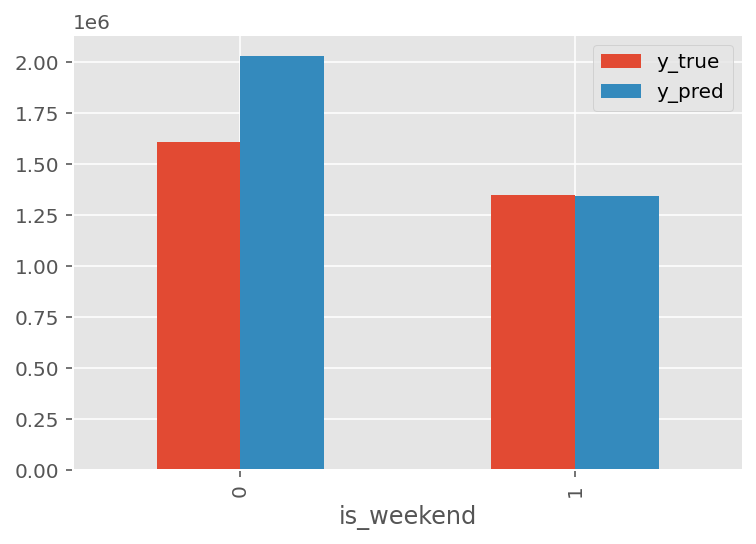

In [38]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');

---

---

## Best Model 결과 분석 Result

### Modeling
- Target변수에 Log Scaling을 적용한 모델의 성능이 더 좋다는 것을 알 수 있다.
- Ensemble Model 중 XGBoost의 성능이 가장 좋다.
- 모든 모델링 결과에서 Label Encoding이 적용된 zip_code의 영향력이 제일 높았다.
    - zip_code의 class의 수가 많았고 해석적인 측면도 고려해야 하기에, Label Encoding 진행
    
### 성능 평가
- datetime : 26 ~ 28 기간에서 실제값보다 예측값이 높게 측정되어 예측이 잘 안되는 것을 알 수 있다.
- hour :  7 ~ 20에서 실제값보다 예측값이 높게 측정.
- weekday : 월, 화에서 실제값보다 예측값이 높게 측정.
- is_weekend : 평일의 실제값보다 예측값이 높게 측정

#### >> 수요가 갑자기 떨어진 기간에 대해서는 예측이 안되는 것을 알 수 있다. (특정 Event에 대해 예측력이 떨어짐.)

### Feature Engineering 진행방향
- 과거 시점의 수요를 데이터로 반영해 학습시킴으로써 Event에 대응할 수 있도록 전처리 진행